In [1]:
def hell(y0, y1, step = 0.2):
    ''' Compute hell distance for two data sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    # generate histgrams for the two data sets
    hist0 = np.histogram(y0, bins = np.arange(a, b, step), density = True)
    hist1 = np.histogram(y1, bins = np.arange(a, b, step), density = True)
    
    return hellinger(hist0[0]/100, hist1[0]/100)

def hellinger(p, q):
    """Hellinger distance between distributions"""
    return np.sqrt(sum([(np.sqrt(t[0])-np.sqrt(t[1]))**2
                for t in zip(p,q)])) / np.sqrt(2.)

Now instead of generate new observed data, we only make small changes to the original observed data and see the sensibility.

In [85]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 15
epsilon = 5000

height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params0= journal0.get_parameters()
print("Posterior mean", journal0.posterior_mean())
print("Covariance matrix:")
print(journal0.posterior_cov())
#print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
distance_data = []
distance_mean_mu = []
distance_mean_sigma = []
hell_mu = []
hell_sigma = []
distance_summary = []

# change of the observed data
e = 1


for i in range(len(height_obs0)):
    # move the observed data slightly
    height_obs = height_obs0*1
    height_obs[i] = height_obs[i]+1
    distance_data.append(np.linalg.norm(np.array(height_obs) - np.array(height_obs0)))
    distance_summary.append(distance_calculator.distance(height_obs, height_obs0))
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    #print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    #print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    
    distance_mean_mu.append(np.linalg.norm(journal.posterior_mean()['mu'] - journal0.posterior_mean()['mu']))
    distance_mean_sigma.append(np.linalg.norm(journal.posterior_mean()['sigma'] - journal0.posterior_mean()['sigma']))
    params = journal.get_parameters()
    
    hell_mu.append(hell(params0['mu'], params['mu']))
    hell_sigma.append(hell(params0['sigma'], params['sigma']))

Posterior mean {'mu': 169.37511375420087, 'sigma': 10.381301776355995}
Covariance matrix:
(array([[47.11476584, -2.09203085],
       [-2.09203085, 15.69297231]]), dict_keys(['mu', 'sigma']))


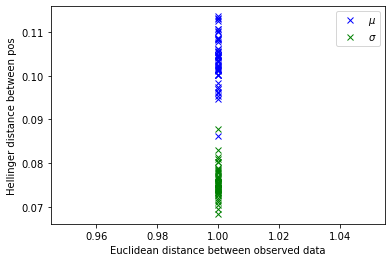

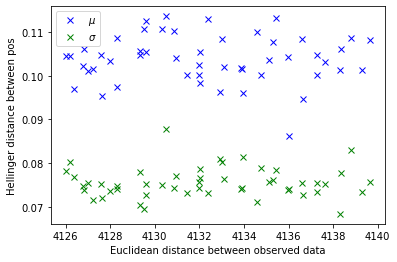

In [88]:
import matplotlib.pyplot as plt

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_data, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_data, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)


plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell1')

plt.show()



fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_summary, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_summary, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)


plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell1')

plt.show()







Analytically, the $\lambda$ for normal distribution can be computed as:

In [87]:
def lamb(mu, sigma, r):
    a =  np.sqrt(2*np.pi)*sigma*np.exp(r**2/(2*(sigma**2)) * ((np.log(2*np.pi* sigma**2))**2/(2*np.pi* sigma**2) + (np.log(2*np.pi* sigma**2)/(2*np.pi*sigma))**2))
    return np.sqrt(a)
    

In [83]:
print(lamb(170, 10, np.linalg.norm(np.array(height_obs)-175)))
#lamb(170, 10, 175)
#print(np.linalg.norm(height_obs))
#print(np.array(height_obs)-175)

14.728450316637343


In [109]:
# Compute estimated density
from sklearn.neighbors import KernelDensity
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.score_samples(X)

array([-0.41075698, -0.41075698, -0.41076071, -0.41075698, -0.41075698,
       -0.41076071])

ValueError: X has 1 features, but KernelDensity is expecting 2 features as input.

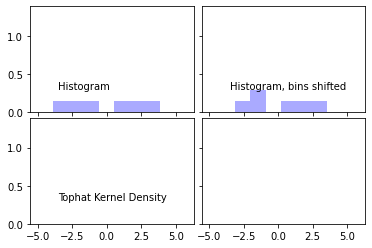

In [96]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X_plot = np.linspace(-5, 5, 6)[:, np.newaxis]
bins = np.linspace(-5, 5, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.2).fit(X)
log_dens = kde.score_samples(X)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x


for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

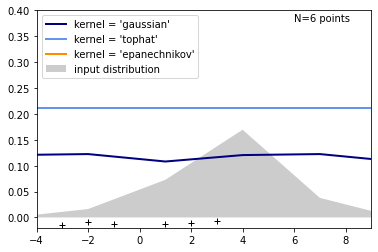

In [108]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# ----------------------------------------------------------------------
# Plot a 1D density example


X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
N = 6
X_plot = np.linspace(-5, 10, N)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()